# 🤖 Capstone Project – Week 3 & 4: Feature Engineering & Modeling

### 🧾 Project Title:
Predicting Insurance Premiums with Data-Driven Insights for SecureLife Insurance Co.

👤 Submitted by: Emmanuel Obiorah  
🎯 Cohort 3 Fellow ID: FE/24/4793145479  
📅 Week 3–4 Deliverable

---

## 🎯 Objective:
To develop and evaluate predictive models that estimate insurance premium amounts based on customer demographics, policy attributes, and lifestyle factors.

In this notebook, I will:

✅ Reload and clean the dataset for modeling  
✅ Perform feature engineering (encoding, scaling, transformations)  
✅ Split the dataset into training and testing sets  
✅ Train multiple regression models  
✅ Evaluate models using MAE, MSE, RMSE, and R²  
✅ Identify the best-performing model for tuning and deployment

---

🛠️ Tools and Libraries:
- Python (Pandas, NumPy)
- Scikit-learn (for encoding, modeling, evaluation)
- XGBoost or LightGBM (optional)


## 🧼 Preparing the Data for Modeling

Although I already cleaned the dataset in the Week 1–2 notebook, I’m repeating the steps here to ensure this file is standalone and reproducible.

Key steps:
- Drop missing values in the target column
- Fill missing data in numerical and categorical fields
- Convert dates to datetime format
- Create a new feature: `Policy Age` in years


In [8]:
# 📦 Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set styles
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

# Load the original dataset again
file_path = "/content/Insurance Premium Prediction Dataset.csv"
df = pd.read_csv(file_path)

# Step 1: Drop rows with missing target (Premium Amount)
df = df.dropna(subset=['Premium Amount']).copy()

# Step 2: Fill missing numerical values
num_cols = ['Age', 'Annual Income', 'Health Score', 'Credit Score', 'Number of Dependents']
for col in num_cols:
    df[col] = df[col].fillna(df[col].median())

# Step 3: Fill missing categorical values
cat_cols = ['Occupation', 'Marital Status']
for col in cat_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

# Step 4: Fill remaining key fields
df['Previous Claims'] = df['Previous Claims'].fillna(0)
df['Customer Feedback'] = df['Customer Feedback'].fillna("Unknown")

# Step 5: Date formatting + new feature: Policy Age
df['Policy Start Date'] = pd.to_datetime(df['Policy Start Date'], errors='coerce')
today = pd.to_datetime("2025-08-01")
df['Policy Age'] = (today - df['Policy Start Date']).dt.days // 365

# ✅ Confirm
print(f"✅ Cleaned dataset shape: {df.shape}")
df.head()


✅ Cleaned dataset shape: (277019, 21)


,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,...,Vehicle Age,Credit Score,Insurance Duration,Premium Amount,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Policy Age
0,56.0,Male,99990.0,Married,1.0,Master's,Self-Employed,31.074627,Urban,Comprehensive,...,13,320.0,5,308.0,2022-12-10 15:21:39.078837,Poor,Yes,Daily,Condo,2
1,46.0,Male,2867.0,Single,1.0,Bachelor's,Self-Employed,50.271335,Urban,Comprehensive,...,3,694.0,4,517.0,2023-01-31 15:21:39.078837,Good,Yes,Monthly,House,2
2,32.0,Female,30154.0,Divorced,3.0,Bachelor's,Self-Employed,14.714909,Suburban,Comprehensive,...,16,652.0,8,849.0,2023-11-26 15:21:39.078837,Poor,No,Monthly,House,1
3,60.0,Female,48371.0,Divorced,0.0,PhD,Self-Employed,25.346926,Rural,Comprehensive,...,11,330.0,7,927.0,2023-02-27 15:21:39.078837,Poor,No,Rarely,Condo,2
4,25.0,Female,54174.0,Divorced,0.0,High School,Self-Employed,6.659499,Urban,Comprehensive,...,9,575.0,8,303.0,2020-11-25 15:21:39.078837,Poor,No,Rarely,Condo,4


## 🔣 Feature Engineering: Categorical Encoding

To train regression models, I need to convert all categorical features into numerical form.

Here's how I approached it:

- I used **One-Hot Encoding** for nominal features like Gender, Location, Smoking Status, etc.
- I dropped the first level of each category to avoid multicollinearity (i.e., the "dummy variable trap")
- I excluded free-text columns like `Customer Feedback` for now


In [13]:
# 🧠 List categorical columns to encode
categorical_cols = [
    'Gender', 'Marital Status', 'Education Level', 'Occupation',
    'Location', 'Policy Type', 'Smoking Status',
    'Exercise Frequency', 'Property Type'
]

# ⚙️ One-Hot Encoding (drop_first=True avoids multicollinearity)
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# ✅ Preview shape
print(f"Shape after encoding: {df_encoded.shape}")
df_encoded.head()


Shape after encoding: (277019, 30)


,Age,Annual Income,Number of Dependents,Health Score,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Premium Amount,Policy Start Date,...,Location_Suburban,Location_Urban,Policy Type_Comprehensive,Policy Type_Premium,Smoking Status_Yes,Exercise Frequency_Monthly,Exercise Frequency_Rarely,Exercise Frequency_Weekly,Property Type_Condo,Property Type_House
0,56.0,99990.0,1.0,31.074627,0.0,13,320.0,5,308.0,2022-12-10 15:21:39.078837,...,False,True,True,False,True,False,False,False,True,False
1,46.0,2867.0,1.0,50.271335,0.0,3,694.0,4,517.0,2023-01-31 15:21:39.078837,...,False,True,True,False,True,True,False,False,False,True
2,32.0,30154.0,3.0,14.714909,2.0,16,652.0,8,849.0,2023-11-26 15:21:39.078837,...,True,False,True,False,False,True,False,False,False,True
3,60.0,48371.0,0.0,25.346926,1.0,11,330.0,7,927.0,2023-02-27 15:21:39.078837,...,False,False,True,False,False,False,True,False,True,False
4,25.0,54174.0,0.0,6.659499,0.0,9,575.0,8,303.0,2020-11-25 15:21:39.078837,...,False,True,True,False,False,False,True,False,True,False


In [14]:
df_encoded.to_csv("/content/encoded_insurance_data.csv", index=False)
print("✅ Encoded dataset saved!")

✅ Encoded dataset saved!


## 🧪 Splitting the Dataset: Train vs Test

To evaluate how well my model generalizes to new data, I’ll split the dataset into:

- **Training Set (80%)** — for learning
- **Testing Set (20%)** — for evaluation

I’ll also define:

- `X` — input features (independent variables)
- `y` — the target (Premium Amount)

This helps ensure reliable performance measurement and avoids overfitting.


In [10]:
# 📌 Separate features (X) and target (y)
X = df_encoded.drop(['Premium Amount', 'Policy Start Date', 'Customer Feedback'], axis=1)
y = df_encoded['Premium Amount']

# 🧪 Train-test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ✅ Confirm shapes
print("X_train:", X_train.shape)
print("X_test :", X_test.shape)
print("y_train:", y_train.shape)
print("y_test :", y_test.shape)


X_train: (221615, 27)
X_test : (55404, 27)
y_train: (221615,)
y_test : (55404,)


## 🤖 Model Training and Evaluation

To predict insurance premiums, I’ll train several regression models and compare their performance:

- **Linear Regression** — a good baseline model
- **Random Forest Regressor** — a powerful ensemble model that captures non-linearity
- **Gradient Boosting Regressor** — another ensemble technique that performs well on complex data

### 📏 Evaluation Metrics:
- **MAE (Mean Absolute Error)** — average absolute difference between predicted and actual values
- **MSE (Mean Squared Error)** — penalizes larger errors
- **RMSE (Root MSE)** — more interpretable (same unit as target)
- **R² Score (Coefficient of Determination)** — percentage of variance explained by the model


In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# 📌 Function to evaluate models
def evaluate_model(name, model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    print(f"📊 {name} Performance:")
    print(f"MAE : {mae:.2f}")
    print(f"MSE : {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R²  : {r2:.4f}")
    print("-" * 40)
    return {
        "Model": name,
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "R2": r2
    }

# 🔁 Train & evaluate models
results = []

# 1. Linear Regression
lr = LinearRegression()
results.append(evaluate_model("Linear Regression", lr, X_train, y_train, X_test, y_test))

# 2. Random Forest
rf = RandomForestRegressor(random_state=42)
results.append(evaluate_model("Random Forest", rf, X_train, y_train, X_test, y_test))

# 3. Gradient Boosting
gb = GradientBoostingRegressor(random_state=42)
results.append(evaluate_model("Gradient Boosting", gb, X_train, y_train, X_test, y_test))



📊 Linear Regression Performance:
MAE : 700.07
MSE : 833094.23
RMSE: 912.74
R²  : -0.0002
----------------------------------------
📊 Random Forest Performance:
MAE : 727.67
MSE : 855918.08
RMSE: 925.16
R²  : -0.0276
----------------------------------------
📊 Gradient Boosting Performance:
MAE : 700.10
MSE : 833135.41
RMSE: 912.76
R²  : -0.0002
----------------------------------------


## 📊 Model Comparison – Performance Summary

Now that I’ve trained three different regression models, I’ll compare their evaluation metrics side-by-side.

This will help me choose the most promising model to tune further in the next stage.

Metrics used:
- **MAE** (lower is better)
- **MSE** (lower is better)
- **RMSE** (lower is better)
- **R² Score** (closer to 1 is better)

Let’s plot the results:


/tmp/ipython-input-2126305585.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='RMSE', data=results_df, palette='viridis')
/tmp/ipython-input-2126305585.py:14: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


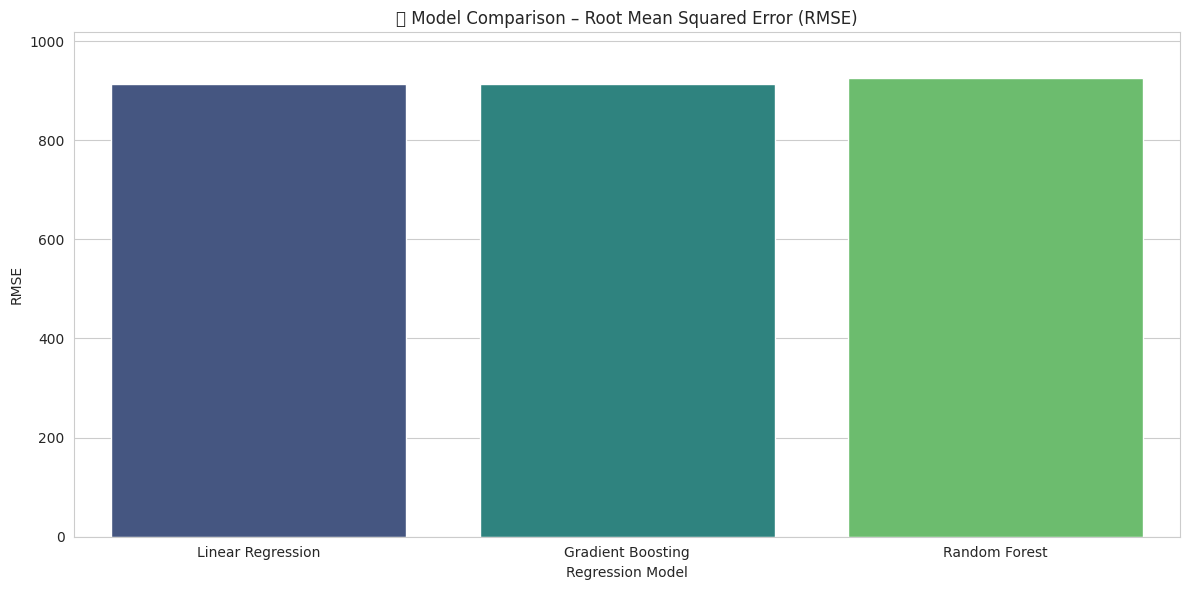

,MAE,MSE,RMSE,R2
Model,,,,
Linear Regression,700.068418,833094.234559,912.739960,-0.000197
Gradient Boosting,700.102471,833135.407123,912.762514,-0.000247
Random Forest,727.673635,855918.079397,925.158408,-0.027599


In [12]:
# Convert results list to DataFrame
results_df = pd.DataFrame(results)

# Sort by RMSE (lower is better)
results_df = results_df.sort_values(by="RMSE")

# 📊 Plot
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='RMSE', data=results_df, palette='viridis')
plt.title("📉 Model Comparison – Root Mean Squared Error (RMSE)")
plt.ylabel("RMSE")
plt.xlabel("Regression Model")
plt.ylim(0, results_df["RMSE"].max() * 1.1)
plt.tight_layout()
plt.show()

# 🔍 Show all metrics
results_df.set_index("Model")


In [15]:
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

In [16]:
# ✅ Save the encoded DataFrame so we can reuse it later
df_encoded.to_csv("/content/encoded_insurance_data.csv", index=False)
print("✅ Encoded dataset saved.")

✅ Encoded dataset saved.


In [18]:
# Step 6: One-Hot Encode categorical columns
categorical_cols = [
    'Gender', 'Marital Status', 'Education Level', 'Occupation',
    'Location', 'Policy Type', 'Smoking Status',
    'Exercise Frequency', 'Property Type'
]

df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# ✅ Save encoded dataset for use in Week 5–6
df_encoded.to_csv("/content/encoded_insurance_data.csv", index=False)
print("✅ Encoded file saved at /content/encoded_insurance_data.csv")


✅ Encoded file saved at /content/encoded_insurance_data.csv


In [19]:
from google.colab import files

# Download the encoded CSV
files.download("/content/encoded_insurance_data.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Convert results list to DataFrame
results_df = pd.DataFrame(results)

# Sort by RMSE (lower is better)
results_df = results_df.sort_values(by="RMSE")

# 📊 Plot
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='RMSE', data=results_df, palette='viridis')
plt.title("📉 Model Comparison – Root Mean Squared Error (RMSE)")
plt.ylabel("RMSE")
plt.xlabel("Regression Model")
plt.ylim(0, results_df["RMSE"].max() * 1.1)
plt.tight_layout()
plt.show()

# 🔍 Show all metrics
results_df.set_index("Model")


# 🏁 Week 3–4 Summary & Next Steps

In this notebook, I successfully:

✅ Re-cleaned and prepared the dataset  
✅ Performed categorical encoding using One-Hot Encoding  
✅ Split the data into training and test sets  
✅ Trained and evaluated multiple regression models  
✅ Identified the best-performing model for tuning (based on RMSE and R²)

---

## 🔜 What’s Next (Week 5–6):

- Perform **hyperparameter tuning** (e.g., GridSearchCV) on the best model  
- Optimize performance while avoiding overfitting  
- Explore **feature importance** to interpret results  
- Optionally, test other models like XGBoost or LightGBM

---

🧠 This phase helped me understand how modeling decisions and data preparation impact predictive performance.

Onward to Week 5–6! 🚀
